# LANL Earthquake Prediction

<a href="https://www.kaggle.com/c/LANL-Earthquake-Prediction/overview">Link to competition on Kaggle</a>

This notebook is a reimplementation of <a href="https://www.kaggle.com/tunguz/andrews-features-only">Andrews Feature Only</a>, with some modifications.

## Feature Engineering

The large training dataset needs to be prepared to closely match the test data, which comprise independent series of 150,000 acoustic measurements. Thus, the training data shall be sliced into separate series of 150,000 measurements, and then summary features will be computed across the training and test series to serve as inputs for modelling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
%%time
train = pd.read_csv('data/raw/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
print(train.shape)
train.head()

(629145480, 2)
Wall time: 2min 55s


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


The dataset is large, occupying 3.5 GB of memory and comprising over 600 million rows. The data can be visualised by sampling a small portion of it.

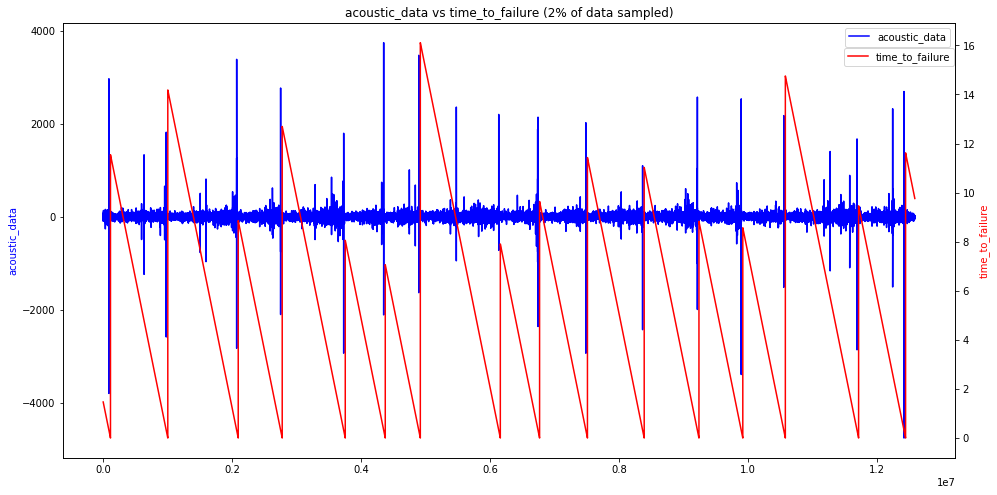

In [4]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("acoustic_data vs time_to_failure (2% of data sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

plt.savefig('reports/figures/acoustic_data_vs_time_to_failure.png')

del train_acoustic_data_small
del train_time_to_failure_small

### Create Segments

Slice the training data into series of 150,000 measurements.

In [5]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

### Generate Features

Compute features for the training and test segments.

In [6]:
 def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    # Short Term Average and Long Term Average
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [7]:
for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [8]:
print("Number of training segments: {}".format(X_tr.shape[0]))
print("Number of features: {}".format(X_tr.shape[1]))
X_tr.head()

Number of training segments: 4194
Number of features: 138


,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113,5.101106,104.0,-98.0,-0.000080,74836.577199,104.0,0.0,6.488552,3.664663,...,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-0.000002,74222.343443,5.629
1,4.725767,6.588824,181.0,-154.0,0.000000,74891.736232,181.0,0.0,7.305233,5.493071,...,0.231587,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002,74364.426478,5.667
2,4.906393,6.967397,140.0,-106.0,-0.000013,75099.224451,140.0,0.0,6.104836,8.603696,...,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,0.000001,74594.984584,5.957
3,4.902240,6.922305,197.0,-199.0,0.000000,74933.991879,199.0,0.0,6.238109,5.652442,...,0.266700,5.858,3.722,4.304,4.433,5.317,5.453,-0.000003,74333.143623,5.858
4,4.908720,7.301110,145.0,-126.0,-0.000007,75010.016046,145.0,0.0,5.323830,7.694506,...,0.228005,6.078,3.918,4.434,4.543,5.306,5.491,0.000002,74428.435969,6.078


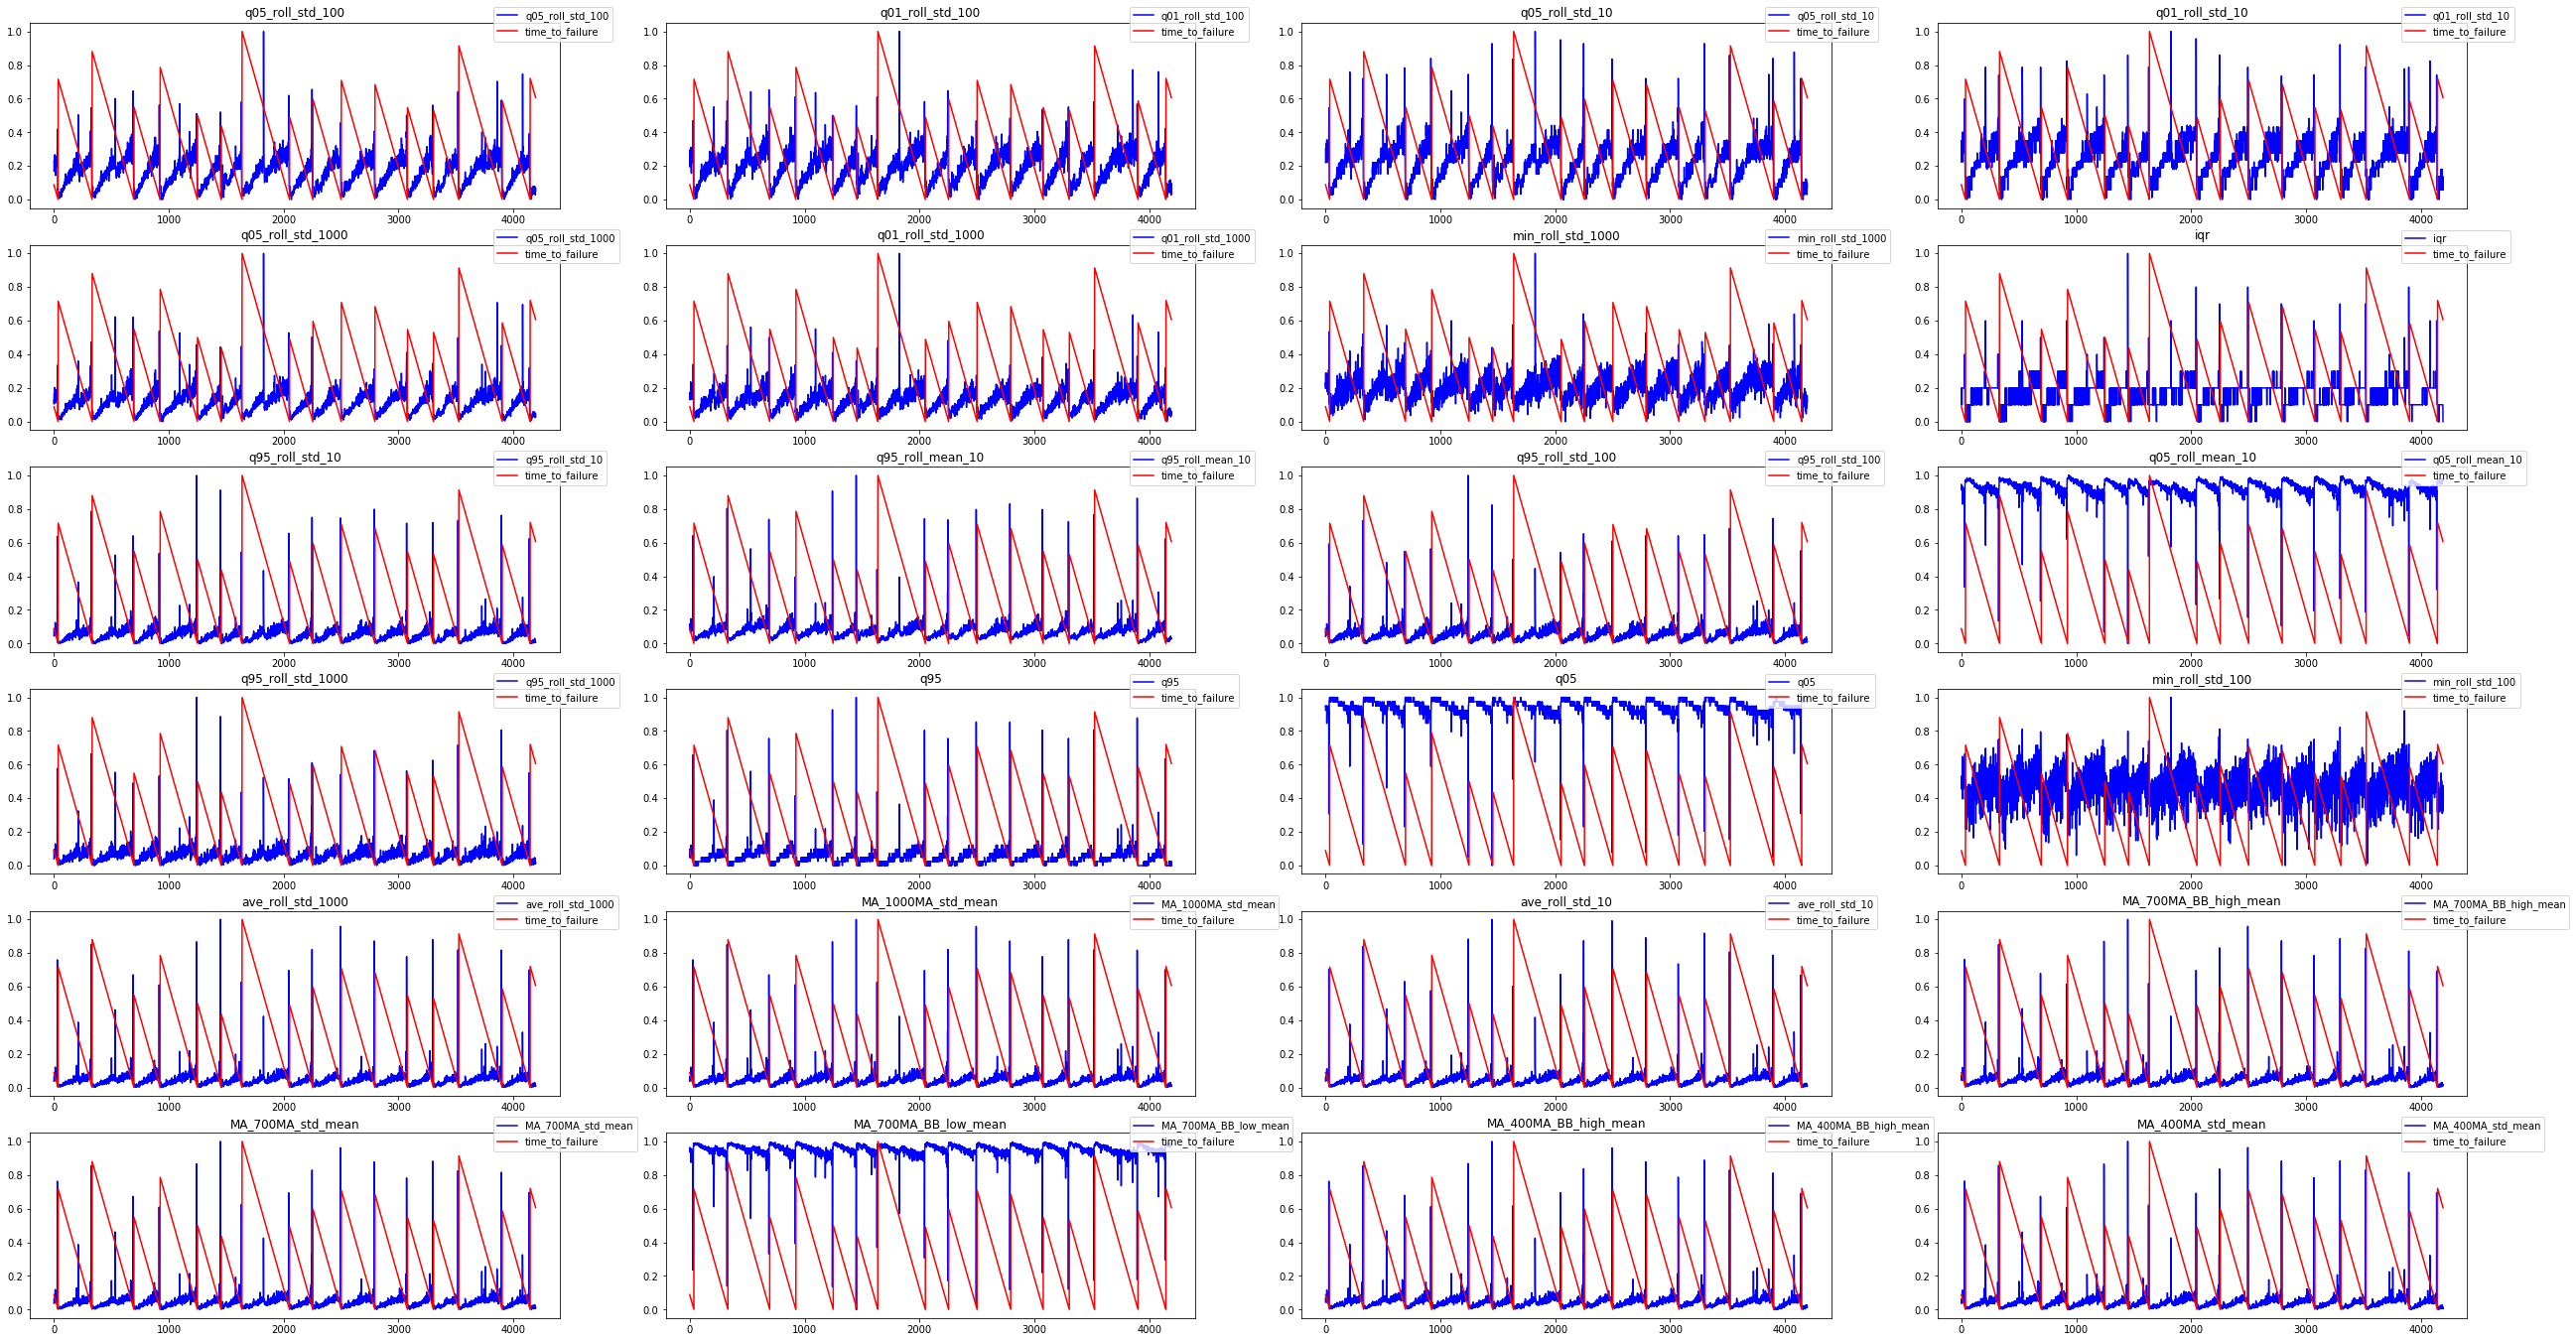

In [9]:
plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
mms = MinMaxScaler()
X_tr_scaled = pd.DataFrame(columns=cols, data=mms.fit_transform(X_tr[cols]))
y_tr_scaled = mms.fit_transform(y_tr)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr_scaled[col], color='b')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr_scaled, color='r')
    ax2.set_ylabel('time_to_failure', color='r')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)
    
plt.savefig('reports/figures/feature_correlations.png')

In [10]:
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('data/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [11]:
X_test.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,4.893690,115.0,-75.0,0.000027,75044.983541,115.0,0.0,5.350451,4.793876,...,0.231891,5.495,3.774,3.889,4.099,4.867,5.000,1.778523e-06,74583.596159,5.495
seg_0012b5,4.171153,5.922839,152.0,-140.0,-0.000013,74949.685653,152.0,0.0,6.249515,4.147562,...,0.230914,5.009,3.342,3.644,3.790,4.541,4.739,-1.946309e-07,74346.833285,5.009
seg_00184e,4.610260,6.946990,248.0,-193.0,-0.000020,74997.632054,248.0,0.0,9.793473,5.225913,...,0.247219,6.234,3.544,4.013,4.215,4.966,5.082,8.053691e-08,74349.464459,6.234
seg_003339,4.531473,4.114147,85.0,-93.0,0.000047,74997.954642,93.0,0.0,3.664088,3.480840,...,0.224909,5.446,3.889,4.032,4.184,4.911,5.051,3.899329e-06,74430.046483,5.446
seg_0042cc,4.128340,5.797164,177.0,-147.0,-0.000007,75075.108147,177.0,0.0,5.321133,7.486142,...,0.274025,5.027,3.357,3.534,3.662,4.570,4.870,-2.939597e-06,74545.727161,5.027


## Save Prepared Datasets

In [13]:
X_tr.to_csv('data/processed/010_train_features.csv', index=False)
X_test.to_csv('data/processed/010_test_features.csv', index=True)